In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.autograd.function import Function
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
from Networks import *
from Networks.VarProjNetwork import *
from Networks.Trajectory import *
from Data.data_processing import *
from Model.model import *

In [2]:
input_len = 24
window = 24
test_index = 2
day_input = "Wednesday"

In [3]:
dataset_train, dataset_test, X_train, y_train, X_test, y_test = data_preprocessing(input_len, window, test_index ,day_input)

print(X_train.shape)
print(y_train.shape)
print(y_test.shape)

(4, 24)
(4, 24)
(1, 24)


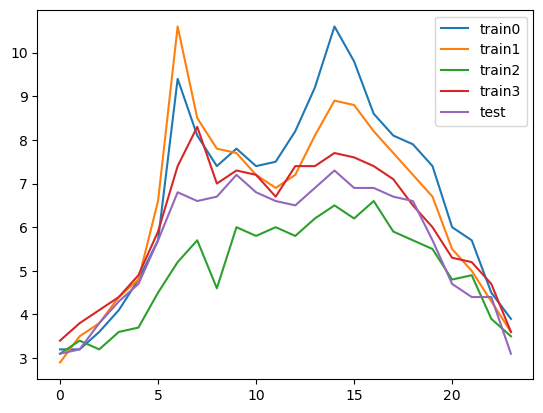

In [4]:
for i in range(len(y_train)):
  plt.plot(y_train[i].squeeze(), label=f"train{i}")

plt.plot(y_test[0].squeeze(), label='test')
plt.legend()

In [5]:
X_train = torch.from_numpy(X_train).float().unsqueeze(1)
y_train = torch.from_numpy(y_train).float().unsqueeze(1)
X_test = torch.from_numpy(X_test).float().unsqueeze(1)
y_test = torch.from_numpy(y_test).float().unsqueeze(1)

In [6]:
params_init = torch.tensor([1.2, 4.2])
model = FCVPNN(24, params_init=params_init)

total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 2384


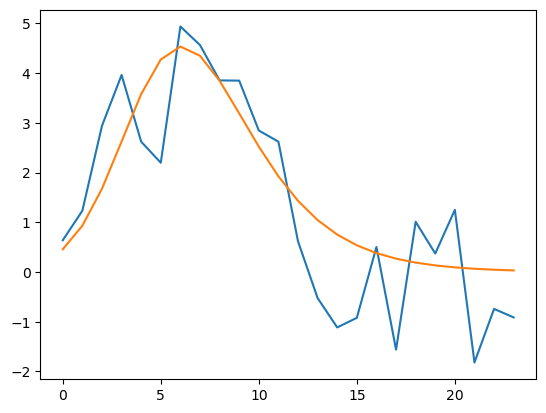

In [7]:
t = np.arange(1,25)
a1 = 1.2
a2 = -0.2
r = 1.3
ny = 2.1

def x_estimate(t,a1,a2,r,ny):
  u = (a1*ny**(1-r) + a2) * np.exp(a1 * (1-r) * t)
  v = ((ny ** (1-r) + a2/a1) * np.exp( a1 * (1-r) * t) - a2/a1)**(r/(1-r))
  return u*v

noise_level = 0.9 # Adjust this value to control the noise magnitude

x_esti = x_estimate(t, a1, a2, r, ny) / 10.0

# Create Gaussian noise
# The shape of the noise should match x_esti
random_noise = noise_level * np.random.randn(*x_esti.shape)

# Add noise to the estimated values
x_target = x_esti + random_noise


plt.plot(x_target)
plt.plot(x_esti)

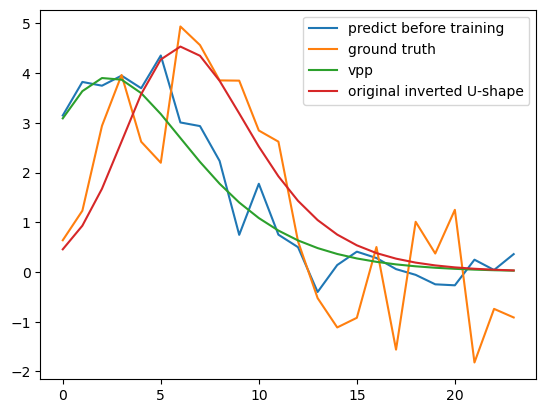

In [8]:
x_input = x_target #df['Vehicles'][5+24*2002:5+24 + 24*2002]/10.0

inputs = torch.tensor(x_input).view(1,1,24).float()
labels =torch.tensor(x_target).view(1,1,24).float()

out_2 , vpp = model(inputs)
out_2 = out_2.view(24).detach().numpy()
vpp = vpp.view(24).detach().numpy()
plt.plot(np.arange(0,24),out_2, label='predict before training')
plt.plot(np.arange(0,24),x_target, label='ground truth')
plt.plot(np.arange(0,24),vpp, label='vpp')
plt.plot(np.arange(0,24),x_esti, label='original inverted U-shape')
plt.legend()

In [9]:
criterion = VPLoss(nn.MSELoss(), 0.5)
optimizer = optim.Adagrad(model.parameters(),
                       lr=0.01,
                       lr_decay=0.001,
                       weight_decay=0.001)

for i in range(3000):
  optimizer.zero_grad()
  outputs = model(inputs)
  loss = criterion(outputs, labels)

  loss.backward()
  optimizer.step()

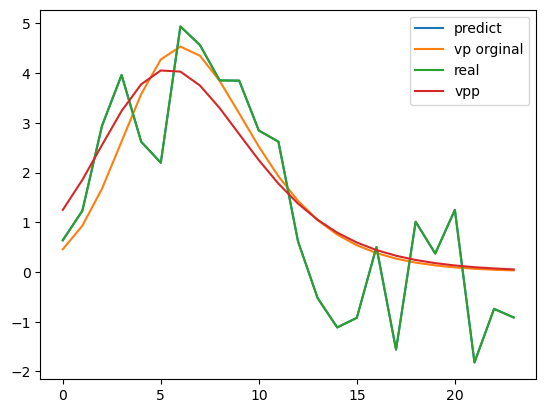

In [10]:
out_2, vpp= model(inputs)
out_2 = out_2.view(24).detach().numpy()
vpp = vpp.view(24).detach().numpy()
plt.plot(np.arange(0,24),out_2, label='predict')
plt.plot(np.arange(0,24),x_esti, label='vp orginal')
plt.plot(np.arange(0,24), x_target, label='real')
plt.plot(np.arange(0,24), vpp, label='vpp')
plt.legend()


In [11]:
model = FCVPNN(24, params_init=params_init)

In [12]:
criterion = VPLoss(nn.MSELoss(), 0.5)
optimizer = optim.Adagrad(model.parameters(),
                       lr=0.01,
                       lr_decay=0.001,
                       weight_decay=0.001)

In [13]:
train_loader, test_loader = load_traffic_real(1, dataset_train, dataset_test)
number_of_observations = len(train_loader.dataset)

In [14]:
def calculate_mape(y_pred, y_true):

    # Calculate absolute percentage error
    absolute_percentage_error = torch.abs((y_pred - y_true) / (y_true))

    # Calculate mean
    mape = torch.mean(absolute_percentage_error) * 100  # Multiply by 100 for percentage

    return mape.item()

In [15]:
mape=[]
mse = []
mae = []
rmse = []

In [16]:
num_epochs=2000
best_mape = float('inf')
hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    running_loss = 0.0
    print(f'Epochs {epoch+1}')

    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0] , data[1]
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        #print(f'outputs shape: {outputs.shape} and {type(outputs)}')
        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        #predict.append(outputs)
    print(f'the loss is : {running_loss}')

    with torch.no_grad():
        y_pred,_ = model(X_train)
        y_test_pred,_ = model(X_test)
        train_mape = calculate_mape(y_train, y_pred)
        print(f'[Epoch: {epoch + 1} Train MAPE: {train_mape:.2f}%')
        test_mape = calculate_mape(y_test,y_test_pred)
        mape.append(test_mape)
        print(f'[Epoch: {epoch + 1}], Test MAPE: {test_mape:.4f}%')

print('Finished Training')

Epochs 1
the loss is : 24.71521282196045
[Epoch: 1 Train MAPE: 13.20%
[Epoch: 1], Test MAPE: 11.7238%
Epochs 2
the loss is : 3.851690411567688
[Epoch: 2 Train MAPE: 8.96%
[Epoch: 2], Test MAPE: 8.5106%
Epochs 3
the loss is : 3.075370132923126
[Epoch: 3 Train MAPE: 7.53%
[Epoch: 3], Test MAPE: 7.4891%
Epochs 4
the loss is : 2.7751136422157288
[Epoch: 4 Train MAPE: 6.74%
[Epoch: 4], Test MAPE: 6.8448%
Epochs 5
the loss is : 2.606432557106018
[Epoch: 5 Train MAPE: 6.30%
[Epoch: 5], Test MAPE: 6.4341%
Epochs 6
the loss is : 2.499935060739517
[Epoch: 6 Train MAPE: 6.05%
[Epoch: 6], Test MAPE: 6.1328%
Epochs 7
the loss is : 2.4279002249240875
[Epoch: 7 Train MAPE: 5.89%
[Epoch: 7], Test MAPE: 5.9099%
Epochs 8
the loss is : 2.3764445185661316
[Epoch: 8 Train MAPE: 5.78%
[Epoch: 8], Test MAPE: 5.7437%
Epochs 9
the loss is : 2.33812552690506
[Epoch: 9 Train MAPE: 5.72%
[Epoch: 9], Test MAPE: 5.6189%
Epochs 10
the loss is : 2.3082753717899323
[Epoch: 10 Train MAPE: 5.67%
[Epoch: 10], Test MAPE: 

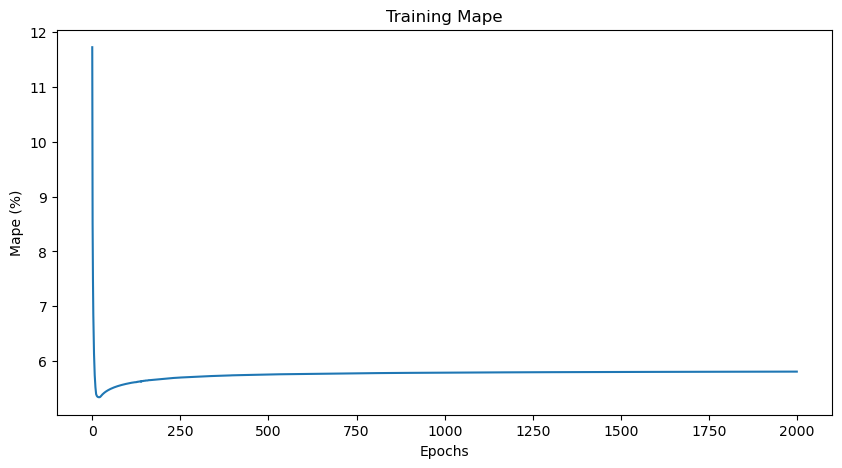

In [17]:
plt.figure(figsize=(10,5))
plt.title("Training Mape")
plt.xlabel('Epochs')
plt.ylabel("Mape (%)")
plt.plot(mape)

(24,)


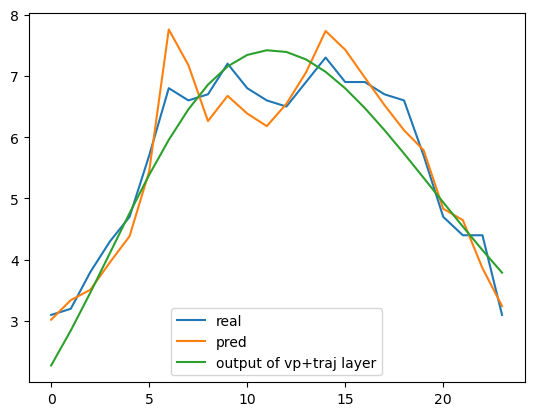

In [18]:
pred1,vp1 = model(X_test[0].unsqueeze(0))
vp1 = vp1.view(24).detach().numpy()
pred1 = pred1.view(24).detach().numpy()
plt.plot(y_test[0].squeeze(), label='real')
plt.plot(pred1, label='pred')
plt.plot(vp1, label='output of vp+traj layer')
plt.legend()
print(pred1.shape)

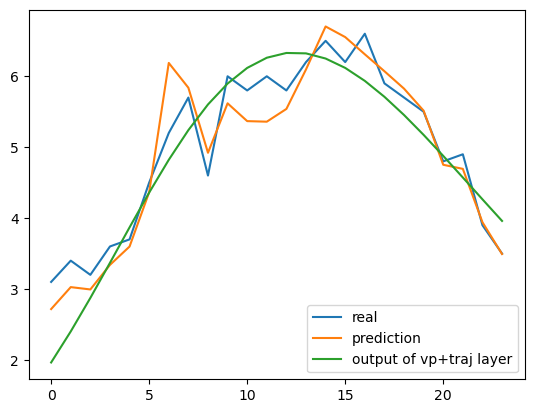

In [19]:
predt0, vpt0 = model(X_train[2].unsqueeze(0))
vpt0 = vpt0.view(24).detach().numpy()
predt0 = predt0.view(24).detach().numpy()
plt.plot(y_train[2].squeeze(), label='real')
plt.plot(predt0, label='prediction')
plt.plot(vpt0, label='output of vp+traj layer')
#plt.ylim(1.0, 8.0)
plt.legend()

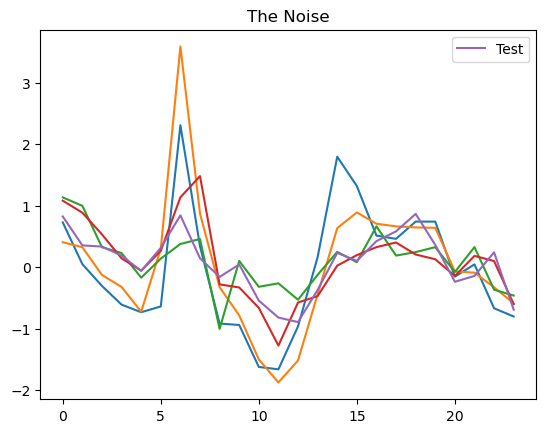

In [20]:
for i in range(len(X_train)):
    predt0, vpt0 = model(X_train[i].unsqueeze(0))
    vpt0 = vpt0.view(24).detach().numpy()
    plt.plot(y_train[i].squeeze() - vpt0)
    
pred1,vp1 = model(X_test[0].unsqueeze(0))
vp1 = vp1.view(24).detach().numpy()
plt.title("The Noise")
plt.plot(y_test[0].squeeze() - vp1, label='Test')
plt.legend()
    

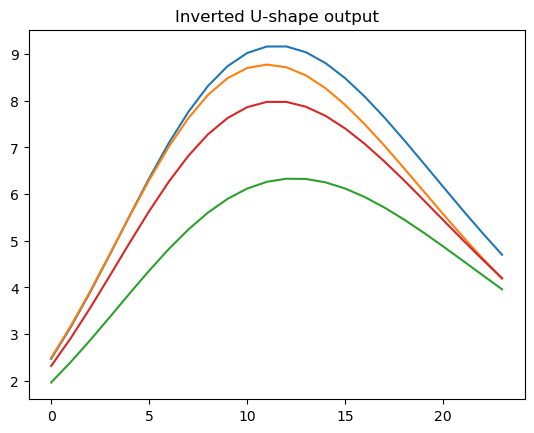

In [21]:
plt.title("Inverted U-shape output")
for i in range(len(X_train)):
    predt0, vpt0 = model(X_train[i].unsqueeze(0))
    vpt0 = vpt0.view(24).detach().numpy()
    plt.plot(vpt0)
    